In [1]:
import numpy as np
np.set_printoptions(precision=4)
from pathlib import Path
import mujoco
import matplotlib.pyplot as plt
import logging
from scipy.spatial import ConvexHull, convex_hull_plot_2d, QhullError
import itertools
import pandas as pd
import cvxopt as cvx

In [2]:
def draw_images(cloth, axis, angle):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for ax, camera in zip(axs, ['robot0_robotview', 'sideview', 'robot0_eye_in_hand']):
        contact_image = Path(contact_data_dir) / f"{cloth}_{axis}_{angle}_{camera}.png"
        ax.imshow(plt.imread(contact_image))
        ax.set_title(camera)
    plt.show()

In [3]:
contact_data_dir = "06042024-132621"
cloth_name, axis, angle = 0, "x", -20
file_path = Path(contact_data_dir) / f"{cloth_name}_{axis}_{angle}.npy"
contacts_0 = np.load(file_path,allow_pickle='TRUE').item()
contacts_0

{'dim': 4,
 'pos': array([[ 0.1786, -0.1093,  0.8415],
        [ 0.1484, -0.0838,  0.8193]]),
 'geom': array([[83, 73],
        [83, 76]], dtype=int32),
 'forces': array([[-6.5050e-01, -7.8112e-01, -7.4336e-01, -5.7498e-01, -4.4436e-01,
         -4.8211e-01,  6.3888e-01,  7.8699e-01,  7.8450e-01,  6.3390e-01,
          4.8578e-01,  4.8827e-01],
        [ 7.9015e-01,  6.4414e-01,  5.9828e-01,  6.9842e-01,  8.4444e-01,
          8.9030e-01, -7.7419e-01, -6.4943e-01, -6.4641e-01, -7.6815e-01,
         -8.9292e-01, -8.9594e-01],
        [-5.0106e-02, -1.5789e-01, -3.7346e-01, -4.8125e-01, -3.7346e-01,
         -1.5789e-01,  2.0607e-01,  9.4288e-02, -1.2928e-01, -2.4107e-01,
         -1.2928e-01,  9.4288e-02],
        [-1.5670e-02, -1.2273e-02, -1.0428e-02, -1.1980e-02, -1.5377e-02,
         -1.7222e-02,  2.8176e-03,  6.9510e-04, -4.0459e-03, -6.6644e-03,
         -4.5420e-03,  1.9903e-04],
        [-1.1777e-02, -1.1606e-02, -5.2529e-03,  9.2903e-04,  7.5806e-04,
         -5.5949e-03, -4.01

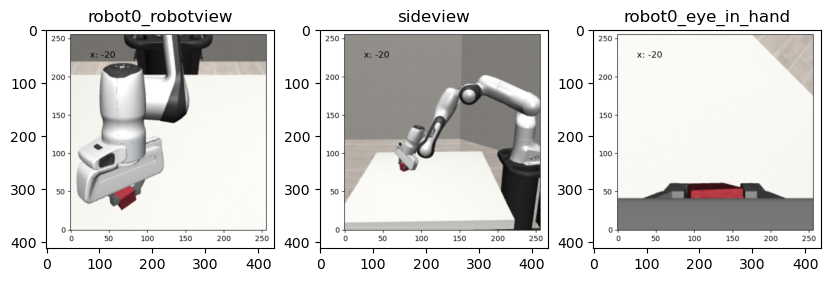

In [4]:
draw_images(cloth_name, axis, angle)

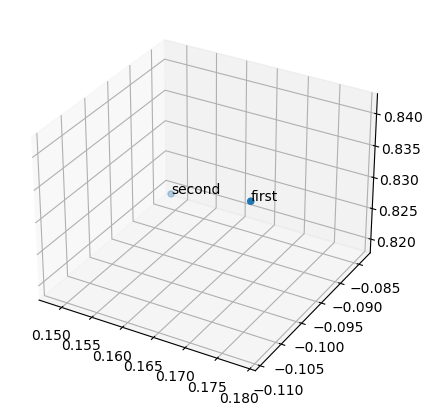

In [5]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

all_coordinates = contacts_0['pos']
ax.scatter(all_coordinates[:, 0], all_coordinates[:, 1], all_coordinates[:, 2])
ax.text(all_coordinates[0, 0], all_coordinates[0, 1], all_coordinates[0, 2], f"first")
ax.text(all_coordinates[1, 0], all_coordinates[1, 1], all_coordinates[1, 2], f"second")
plt.savefig("contact_points.png", bbox_inches='tight')
plt.show()

Text(0.14840957351831963, -0.08375750062080757, 'second')

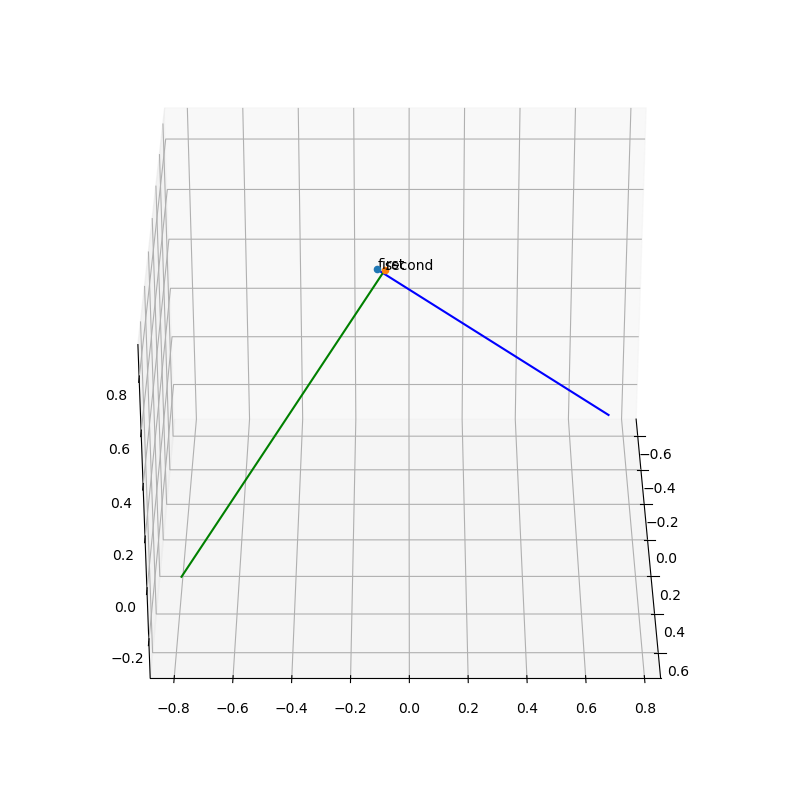

In [6]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 0, 0)
point_x, point_y, point_z = contacts_0['pos'][0]
normal_x, normal_y, normal_z = -(contacts_0['frame'][0][:3])
plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="blue")
ax.scatter(point_x, point_y, point_z)
# ax.text(point_x , point_y, point_z, f"first: {point_x:.2f}, {point_y:.2f}, {point_z:.2f}")
ax.text(point_x , point_y, point_z, f"first")


point_x, point_y, point_z = contacts_0['pos'][1]
normal_x, normal_y, normal_z = -(contacts_0['frame'][1][:3])
plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="green")
ax.scatter(point_x, point_y, point_z)
# ax.text(point_x , point_y, point_z, f"first: {point_x:.2f}, {point_y:.2f}, {point_z:.2f}")
ax.text(point_x , point_y, point_z, f"second")

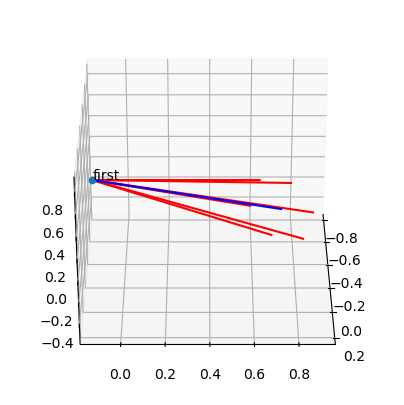

In [19]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
scale=1.0

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 0, 0)

point_x, point_y, point_z = contacts_0['pos'][0]
cone_support = contacts_0['forces'][:3, :6]
normal_x, normal_y, normal_z = -(contacts_0['frame'][0][:3])

for i in range(cone_support.shape[1]):
    dest = cone_support[:,i]
    plt.plot((point_x, dest[0]), (point_y, dest[1]), (point_z, dest[2]), color="red")

plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="blue")
ax.scatter(point_x, point_y, point_z)
# ax.text(point_x , point_y, point_z, f"first: {point_x:.2f}, {point_y:.2f}, {point_z:.2f}")
ax.text(point_x , point_y, point_z, f"first")
plt.savefig("first_contact_cone.png", bbox_inches='tight')

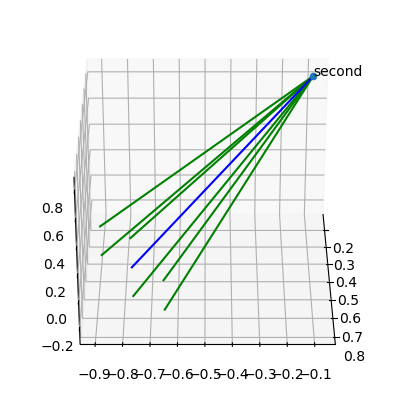

In [20]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 0, 0)

point_x, point_y, point_z = contacts_0['pos'][1]
cone_support = contacts_0['forces'][:3, 6:]
normal_x, normal_y, normal_z = -(contacts_0['frame'][1][:3])

for i in range(cone_support.shape[1]):
    dest = cone_support[:,i]
    plt.plot((point_x, dest[0]), (point_y, dest[1]), (point_z, dest[2]), color="green")

plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="blue")
ax.scatter(point_x, point_y, point_z)
ax.text(point_x, point_y, point_z, f"second")
plt.savefig("second_contact_cone.png", bbox_inches='tight')
plt.show()

Text(0.14840957351831963, -0.08375750062080757, 'second')

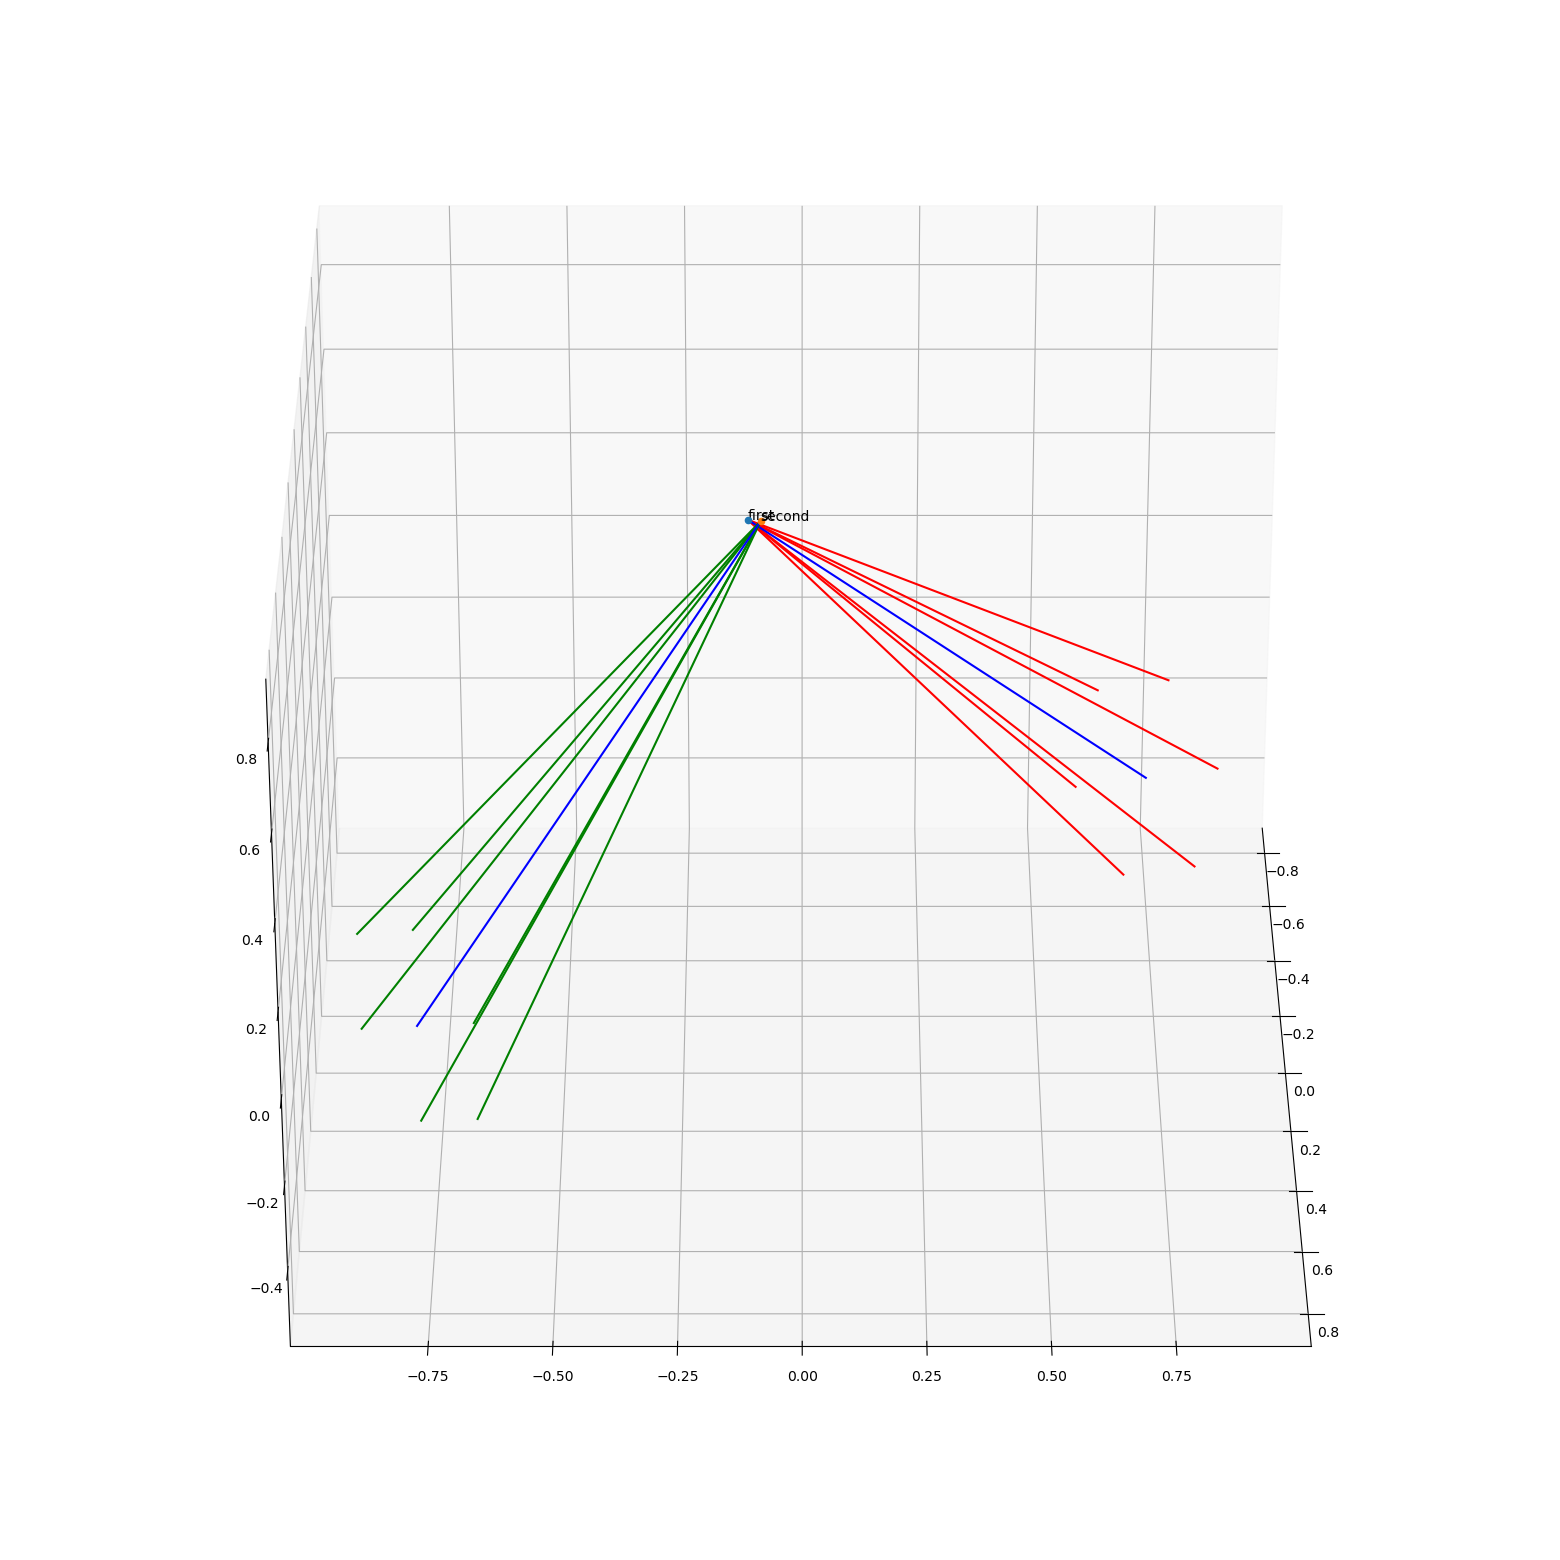

In [18]:
scale=1.0

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
ax.view_init(30, 0, 0)

point_x, point_y, point_z = contacts_0['pos'][0]
cone_support = contacts_0['forces'][:3, :6]
normal_x, normal_y, normal_z = -(contacts_0['frame'][0][:3])

for i in range(cone_support.shape[1]):
    dest = cone_support[:,i]
    plt.plot((point_x, dest[0]), (point_y, dest[1]), (point_z, dest[2]), color="red")

plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="blue")
ax.scatter(point_x, point_y, point_z)
# ax.text(point_x , point_y, point_z, f"first: {point_x:.2f}, {point_y:.2f}, {point_z:.2f}")
ax.text(point_x , point_y, point_z, f"first")

point_x, point_y, point_z = contacts_0['pos'][1]
cone_support = contacts_0['forces'][:3, 6:]
normal_x, normal_y, normal_z = -(contacts_0['frame'][1][:3])

for i in range(cone_support.shape[1]):
    dest = cone_support[:,i]
    plt.plot((point_x, dest[0]), (point_y, dest[1]), (point_z, dest[2]), color="green")

plt.plot((point_x, normal_x), (point_y, normal_y), (point_z, normal_z), color="blue")
ax.scatter(point_x, point_y, point_z)
ax.text(point_x, point_y, point_z, f"second")

In [10]:
contacts_0['forces'].shape

(6, 12)

In [11]:
contacts_0['forces']

array([[-6.5050e-01, -7.8112e-01, -7.4336e-01, -5.7498e-01, -4.4436e-01,
        -4.8211e-01,  6.3888e-01,  7.8699e-01,  7.8450e-01,  6.3390e-01,
         4.8578e-01,  4.8827e-01],
       [ 7.9015e-01,  6.4414e-01,  5.9828e-01,  6.9842e-01,  8.4444e-01,
         8.9030e-01, -7.7419e-01, -6.4943e-01, -6.4641e-01, -7.6815e-01,
        -8.9292e-01, -8.9594e-01],
       [-5.0106e-02, -1.5789e-01, -3.7346e-01, -4.8125e-01, -3.7346e-01,
        -1.5789e-01,  2.0607e-01,  9.4288e-02, -1.2928e-01, -2.4107e-01,
        -1.2928e-01,  9.4288e-02],
       [-1.5670e-02, -1.2273e-02, -1.0428e-02, -1.1980e-02, -1.5377e-02,
        -1.7222e-02,  2.8176e-03,  6.9510e-04, -4.0459e-03, -6.6644e-03,
        -4.5420e-03,  1.9903e-04],
       [-1.1777e-02, -1.1606e-02, -5.2529e-03,  9.2903e-04,  7.5806e-04,
        -5.5949e-03, -4.0189e-04, -1.1794e-03, -2.1332e-03, -2.3095e-03,
        -1.5320e-03, -5.7822e-04],
       [ 1.7718e-02,  1.3370e-02,  1.2342e-02,  1.5661e-02,  2.0010e-02,
         2.1038e-02, -

In [12]:
np.linalg.matrix_rank(contacts_0['forces'][:3, :])

3

In [13]:
contacts_0['forces'][:,0]

array([-0.6505,  0.7902, -0.0501, -0.0157, -0.0118,  0.0177])

In [14]:
ConvexHull(contacts_0['forces'][:5, :].T).volume

1.0191655481266326e-06